In [1]:
# from future import print_function
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import argparse
import torch.utils.data as data
import sys
sys.path.append(os.path.abspath(".."))
from data import WiderFaceDetection, detection_collate, preproc, cfg_mnet, cfg_re50
from layers.modules import MultiBoxLoss
from layers.functions.prior_box import PriorBox
import time
import datetime
import math
from models.retinaface import RetinaFace
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda:0


In [3]:
# Declare config (use resnet50 backbone)
cfg = cfg_re50
rgb_mean = (104, 117, 123) # bgr order
num_classes = 2
img_dim = cfg['image_size']
num_gpu = cfg['ngpu']
batch_size = cfg['batch_size']
max_epoch = cfg['epoch']
gpu_train = cfg['gpu_train']

initial_lr = 1e-3
momentum = 0.9
weight_decay = 5e-4

In [4]:
# csv_file = "../data/fairface/fairface_label_train.csv"
# df = pd.read_csv(csv_file)

# # Separate male and female images
# female_images = df[df["gender"] == 'Female']['file'].tolist()
# male_images = df[df['gender'] == 'Male']['file'].tolist()

# black_images = df[df["race"] == 'Black']['file'].tolist()
# white_images = df[df["race"] == 'White']['file'].tolist()
# indian_images = df[df["race"] == 'Indian']['file'].tolist()

# print(f"Number of Female Images: {len(female_images)}")
# print(f"Number of Male Images: {len(male_images)}")
# print(f"Number of Black Images: {len(black_images)}")
# print(f"Number of White Images: {len(white_images)}")

In [5]:
# Instantiate model with the configurations above
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        pretrained_dict = torch.load(pretrained_path, map_location=device)
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

model = RetinaFace(cfg=cfg, phase="test").to(device)
model = load_model(model, "../weights/Resnet50_Final.pth", False)
model.eval()

/common/home/users/n/nicoleoo.2021/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/common/home/users/n/nicoleoo.2021/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pretrained model from ../weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


RetinaFace(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [6]:
from utils.nms.py_cpu_nms import py_cpu_nms
from utils.box_utils import decode, decode_landm

def test_forward_pass(image_path, model, confidence_threshold):
    resize = 1
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)

    img = np.float32(img_raw)

    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)
    loc, conf, landms = model(img)  # forward pass
    print(f"loc: {loc.shape}, conf: {conf.shape}, landms: {landms.shape}")
    print(f"loc is {loc}, conf is {conf}, landms is {landms}")

    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data

    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()

    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])

    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMSk
    top_k = 5000
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    nms_threshold = 0.4
    keep = py_cpu_nms(dets, nms_threshold)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    keep_top_k = 750
    dets = dets[:keep_top_k, :]
    landms = landms[:keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)

    total_detected_faces = 0
    has_detected_face = False
    visualization_threshold = 0.6
    confidence_score = 0

    for b in dets:
        if b[4] < visualization_threshold:
            continue
        
        has_detected_face = True
        total_detected_faces += 1
        confidence_score += b[4]

        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
        cx = b[0]
        cy = b[1] + 12
        cv2.putText(img_raw, text, (cx, cy),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

        # landms
        cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
        cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
        cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
        cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
        cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)
    
    if total_detected_faces == 1:
        # save image
        base_file_name = os.path.basename(image_path)
        name = f"./Testing/{base_file_name}"
        cv2.imwrite(name, img_raw)

    if has_detected_face:
        return 1, confidence_score
    else:
        return 0, confidence_score

In [ ]:
from utils.nms.py_cpu_nms import py_cpu_nms
from utils.box_utils import decode, decode_landm

def test_forward_pass_2(img, model, confidence_threshold):
    resize = 1

    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)
    loc, conf, landms = model(img)  # forward pass
    print(f"loc: {loc.shape}, conf: {conf.shape}, landms: {landms.shape}")
    print(f"loc is {loc}, conf is {conf}, landms is {landms}")

    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data

    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()

    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])

    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMSk
    top_k = 5000
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    nms_threshold = 0.4
    keep = py_cpu_nms(dets, nms_threshold)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    keep_top_k = 750
    dets = dets[:keep_top_k, :]
    landms = landms[:keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)

    total_detected_faces = 0
    has_detected_face = False
    visualization_threshold = 0.6
    confidence_score = 0

    for b in dets:
        if b[4] < visualization_threshold:
            continue
        
        has_detected_face = True
        total_detected_faces += 1
        confidence_score += b[4]

        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
        cx = b[0]
        cy = b[1] + 12
        cv2.putText(img_raw, text, (cx, cy),
                    cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

        # landms
        cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
        cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
        cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
        cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
        cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)
    
    if total_detected_faces == 1:
        # save image
        base_file_name = os.path.basename(image_path)
        name = f"./Testing/{base_file_name}"
        cv2.imwrite(name, img_raw)

    if has_detected_face:
        return 1, confidence_score
    else:
        return 0, confidence_score

In [7]:
# Accuracy Based Fairness Computation
def computeFairnessWithAccuracy(folder_path):
    file_names = os.listdir(folder_path)

    total_detected_faces = 0
    total_confidence_score = 0
    for file_name in file_names:
        image_path = f"{folder_path}{file_name}"
        detected, confidence_score = test_forward_pass(image_path, model, 0.99)
        if detected == 0:
            print(f"Failed to detect face in {image_path}")
        total_detected_faces += detected
        total_confidence_score += confidence_score
    
    accuracy = total_detected_faces / 100 * 100
    avg_confidence_score = total_confidence_score / 100
    return accuracy, avg_confidence_score

In [8]:
# # Computing fairness for black race images
# black_folder_path = "../data/fairface/filtered/black/"
# accuracy_black, avg_confidence_score_black = computeFairnessWithAccuracy(black_folder_path)

# print(f"Accuracy = {accuracy_black}")
# print(f"Average confidence score = {avg_confidence_score_black}")

In [9]:
# # Computing fairness for indian race images
# indian_folder_path = "../data/fairface/filtered/indian/"
# accuracy_indian, avg_confidence_score_indian = computeFairnessWithAccuracy(indian_folder_path)

# print(f"Accuracy = {accuracy_indian}")
# print(f"Average confidence score = {avg_confidence_score_indian}")

In [10]:
# # Computing fairness for white race images
# white_folder_path = "../data/fairface/filtered/white/"
# accuracy_white, avg_confidence_score_white = computeFairnessWithAccuracy(white_folder_path)

# print(f"Accuracy = {accuracy_white}")
# print(f"Average confidence score = {avg_confidence_score_white}")

In [11]:
# categories = ['Black Faces', 'Indian Faces', 'White Faces']
# # categories = ['Black Faces', 'White Faces']
# accuracies = [accuracy_black, accuracy_indian, accuracy_white]
# avg_confidence_score = [avg_confidence_score_black, avg_confidence_score_indian, avg_confidence_score_white]
# # avg_confidence_score = [avg_confidence_score_black, avg_confidence_score_white]
# avg_confidence_score = [x * 100 for x in avg_confidence_score]

# plt.figure(figsize=(8,6))
# plt.bar(categories, avg_confidence_score, color=['pink', 'blue', 'red'])
# plt.xlabel('Race')
# plt.ylabel('Detection Accuracy (%)')
# plt.title('Detection Accuracy of Different Races')
# plt.ylim(97,100)

# for i, v in enumerate(avg_confidence_score):
#     plt.text(i, v+0.05, f"{v:.5f}%", ha='center', fontsize=12)

# plt.show()

# Adversarial Discriminatory Finder Attack

### Load and normalise the image here

In [12]:
import torchvision.transforms as transforms

def load_and_normalize_image(image_path, device='cuda'):
    """
    Load an image from file, convert to tensor, and normalize it
    
    Args:
        image_path: Path to the image file
        device: Device to put the tensor on
        
    Returns:
        Normalized image tensor on the specified device
    """
    # Load image using PIL
    image = Image.open(image_path).convert('RGB')
    
    # Define preprocessing pipeline
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to model's expected input size
        transforms.ToTensor(),  # Convert to tensor (scales to [0, 1])
    ])
    
    # Apply transformations
    image_tensor = transform(image)
    
    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    return image_tensor

### Pertubation using FGSM

In [13]:
import torch.nn as nn
import torch.nn.functional as F

# This FGSM pertubation function will produce adversarial samples to find discriminative features
def fgsm(model, x, eps=0.1):
    x_adv = x.detach().clone()
    x_adv.requires_grad = True
    x_adv = x_adv.to(device)

     # Forward pass through the model
    loc, conf, landms = model(x_adv)

    # Extract confidence scores (classification output)
    scores = conf.squeeze(0)  # Shape: [num_priors, 2] (face/no-face)

    # We assume the attack is targeting the face detection confidence
    face_scores = scores[:, 1]  # Only take the "face" confidence scores

    # Create fake target (try to reduce face confidence)
    target = torch.zeros_like(face_scores, dtype=torch.long).to(device)  # Targeting "no-face" (label 0)

    # Compute loss
    loss = F.cross_entropy(scores, target)

    # Backpropagate to compute gradients
    loss.backward()

    # Apply FGSM perturbation
    x_adv = torch.clamp(x_adv + eps * x_adv.grad.sign(), 0, 1).detach()

    # Re-run the model on the adversarial image
    _, conf_adv, _ = model(x_adv)

    # Check if attack was successful (confidence reduced)
    new_scores = conf_adv.squeeze(0)[:, 1]  # New face confidence
    original_confidence = face_scores.mean().item()
    adversarial_confidence = new_scores.mean().item()

    if adversarial_confidence < original_confidence:
        print(f"Attack successful! Original confidence: {original_confidence:.4f}, Adversarial confidence: {adversarial_confidence:.4f}")
        return x_adv  # Return adversarial image
    else:
        print("Attack unsuccessful. Model prediction remains unchanged.")
        return None

### Check whether the sample is discriminative

In [14]:
def isDiscriminative(original_tensor, perturbed_tensor, model, confidence_threshold=0.5, reduction_threshold=0.3, device='cuda'):
    """
    Determines if a perturbed image tensor is 'discriminative' based on confidence decrease
    or face detection failure.
    
    Args:
        original_tensor: Original image tensor
        perturbed_tensor: Perturbed/adversarial image tensor
        model: Face detection model
        confidence_threshold: Threshold for face detection
        reduction_threshold: Minimum confidence reduction to consider successful (0.3 = 30%)
        device: Device to run computation on
        
    Returns:
        Boolean indicating if the perturbed image is discriminative
    """
    # Make sure tensors are on the correct device
    original_tensor = original_tensor.to(device)
    perturbed_tensor = perturbed_tensor.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Process original tensor
    with torch.no_grad():
        # Get results from original tensor
        loc_orig, conf_orig, landms_orig = model(original_tensor)
        scores_orig = conf_orig.squeeze(0).data.cpu().numpy()[:, 1]
        
        # Check if original has faces
        orig_has_face = np.any(scores_orig > confidence_threshold)
        orig_confidence = np.mean(scores_orig[scores_orig > confidence_threshold]) if orig_has_face else 0
        
        # Process perturbed tensor
        loc_pert, conf_pert, landms_pert = model(perturbed_tensor)
        scores_pert = conf_pert.squeeze(0).data.cpu().numpy()[:, 1]
        
        # Check if perturbed has faces
        pert_has_face = np.any(scores_pert > confidence_threshold)
        pert_confidence = np.mean(scores_pert[scores_pert > confidence_threshold]) if pert_has_face else 0
    
    # Calculate confidence reduction
    if not orig_has_face:
        print("Original image doesn't have a detected face!")
        return False
    
    # Check if face detection failed completely
    if not pert_has_face:
        print("Attack successful! No face detected in perturbed image.")
        return True
    
    # Calculate confidence reduction
    absolute_reduction = orig_confidence - pert_confidence
    relative_reduction = absolute_reduction / orig_confidence if orig_confidence > 0 else 0
    
    # Print confidence scores and reduction
    print(f"Original confidence: {orig_confidence:.4f}")
    print(f"Perturbed confidence: {pert_confidence:.4f}")
    print(f"Absolute reduction: {absolute_reduction:.4f}")
    print(f"Relative reduction: {relative_reduction:.4f} ({relative_reduction*100:.2f}%)")
    
    # Determine if the reduction is significant enough
    is_discriminative = relative_reduction >= reduction_threshold
    
    if is_discriminative:
        print("Attack successful: Confidence reduced significantly")
    else:
        print("Attack unsuccessful: Confidence not reduced enough")
    
    return is_discriminative

In [15]:
import torch

def fgsm_attack(model, x, eps=0.1, iterations=1, target_confidence=0.3, device='cuda', img_path=None):
    # Keep original for comparison
    x_orig = x.clone().detach()
    
    # Create adversarial example
    x_adv = x.clone().detach().to(device)
    
    # Get original predictions
    with torch.no_grad():
        loc_orig, conf_orig, landms_orig = model(x_orig.to(device))
        print("------------------------")
        print(conf_orig)
        print("------------------------")
        orig_face_conf = conf_orig.squeeze(0)[:, 1]
        orig_confidence = orig_face_conf.mean().item()
        print(f"Original confidence: {orig_confidence:.4f}")
    
    # Iterative FGSM (more effective than single-step)
    for i in range(iterations):
        x_adv.requires_grad = True
        
        # Forward pass
        loc, conf, landms = model(x_adv)
        print(loc, conf, landms)
        
        # Extract confidence scores
        face_scores = conf.squeeze(0)[:, 1]  # Face confidence scores
        
        # For detection models, we want to minimize face confidence
        loss = face_scores.mean()  # Directly minimize face confidence
        
        # Zero gradients
        # if x_adv.grad is not None:
        #     x_adv.grad.data.zero_()
        
        # Backpropagate
        loss.backward()
        
        # Calculate perturbation
        with torch.no_grad():
            # Apply FGSM step
            grad_sign = x_adv.grad.sign()
            x_adv = x_adv.detach() - (eps/iterations) * grad_sign  # Note the minus sign to reduce confidence
            
            # Project back to valid image range
            x_adv = torch.clamp(x_adv, 0, 1)
        
        # Check progress
        if (i+1) % 5 == 0 or i == 0:
            with torch.no_grad():
                _, conf_curr, _ = model(x_adv)
                curr_confidence = conf_curr.squeeze(0)[:, 1].mean().item()
                print(f"Iteration {i+1}: confidence = {curr_confidence:.4f}")
                
                # Early stopping if we reach target confidence
                if curr_confidence < target_confidence:
                    print(f"Target confidence reached at iteration {i+1}")
                    break
    
    # Evaluate attack success
    with torch.no_grad():
        _, conf_adv, _ = model(x_adv)
        adv_confidence = conf_adv.squeeze(0)[:, 1].mean().item()
        
        # Calculate perturbation magnitude
        perturbation = (x_adv - x_orig).abs().mean().item()
        
        print(f"Final results:")
        print(f"Original confidence: {orig_confidence:.4f}")
        print(f"Adversarial confidence: {adv_confidence:.4f}")
        print(f"Average perturbation magnitude: {perturbation:.4f}")
        
        if adv_confidence < orig_confidence:
            success_rate = (orig_confidence - adv_confidence) / orig_confidence * 100
            print(f"Attack successful! Confidence reduced by {success_rate:.2f}%")
            return x_adv
        else:
            print("Attack unsuccessful. Model prediction remains robust.")
            return None

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

def display_adversarial_sample(original_tensor, adversarial_tensor, figsize=(12, 6)):
    """
    Display original and adversarial images side by side
    
    Args:
        original_tensor: Original image tensor
        adversarial_tensor: Adversarial image tensor
        figsize: Figure size for the plot
    """
    # Move tensors to CPU if they're on GPU
    if original_tensor.is_cuda:
        original_tensor = original_tensor.cpu()
    if adversarial_tensor.is_cuda:
        adversarial_tensor = adversarial_tensor.cpu()
    
    # Remove batch dimension if present
    if original_tensor.dim() == 4:
        original_tensor = original_tensor.squeeze(0)
    if adversarial_tensor.dim() == 4:
        adversarial_tensor = adversarial_tensor.squeeze(0)
    
    # Convert to numpy arrays
    original_np = original_tensor.permute(1, 2, 0).numpy()  # Convert from [C, H, W] to [H, W, C]
    adversarial_np = adversarial_tensor.permute(1, 2, 0).numpy()
    
    # If normalized, denormalize (assuming [0,1] range)
    if original_np.min() < 0 or original_np.max() > 1:
        # Assuming ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        original_np = original_np * std + mean
        # adversarial_np = adversarial_np * std + mean
        
        # Clip to [0,1]
        original_np = np.clip(original_np, 0, 1)
        adversarial_np = np.clip(adversarial_np, 0, 1)
    
    # Calculate difference
    difference = np.abs(adversarial_np - original_np)
    
    # Enhance difference visualization (scale it up)
    difference_enhanced = difference * 5.0
    difference_enhanced = np.clip(difference_enhanced, 0, 1)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_np)
    plt.title('Original Image')
    plt.axis('off')
    
    # Display adversarial image
    plt.subplot(1, 3, 2)
    plt.imshow(adversarial_np)
    plt.title('Adversarial Image')
    plt.axis('off')
    
    # Display difference
    plt.subplot(1, 3, 3)
    plt.imshow(difference_enhanced)
    plt.title('Difference (Enhanced)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print perturbation statistics
    l2_dist = np.sqrt(np.sum((original_np - adversarial_np) ** 2))
    l0_dist = np.sum(np.abs(original_np - adversarial_np) > 1e-6)
    l_inf = np.max(np.abs(original_np - adversarial_np))
    
    print(f"Perturbation statistics:")
    print(f"L2 distance: {l2_dist:.6f}")
    print(f"L0 norm (changed pixels): {l0_dist}")
    print(f"L∞ norm (max change): {l_inf:.6f}")

------------------------
tensor([[[9.9980e-01, 1.9734e-04],
         [9.9989e-01, 1.0840e-04],
         [9.9969e-01, 3.0572e-04],
         ...,
         [9.9943e-01, 5.6926e-04],
         [9.9987e-01, 1.3260e-04],
         [9.9996e-01, 3.5611e-05]]], device='cuda:0')
------------------------
Original confidence: 0.0006
tensor([[[ 1.2615,  2.6714, -1.3116,  0.4375],
         [ 2.0715,  3.3548, -1.3915,  0.5581],
         [-0.5796,  2.9679,  0.0935,  0.3410],
         ...,
         [-0.0803, -0.3138, -0.6607, -0.8517],
         [-0.0448, -0.1810, -1.3119, -0.8402],
         [ 0.0451, -0.0409, -1.6647, -1.4225]]], device='cuda:0',
       grad_fn=<CatBackward0>) tensor([[[9.9980e-01, 1.9734e-04],
         [9.9989e-01, 1.0840e-04],
         [9.9969e-01, 3.0572e-04],
         ...,
         [9.9943e-01, 5.6926e-04],
         [9.9987e-01, 1.3260e-04],
         [9.9996e-01, 3.5611e-05]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>) tensor([[[-0.6274,  1.3143,  2.8965,  ...,  7.6051,  2.

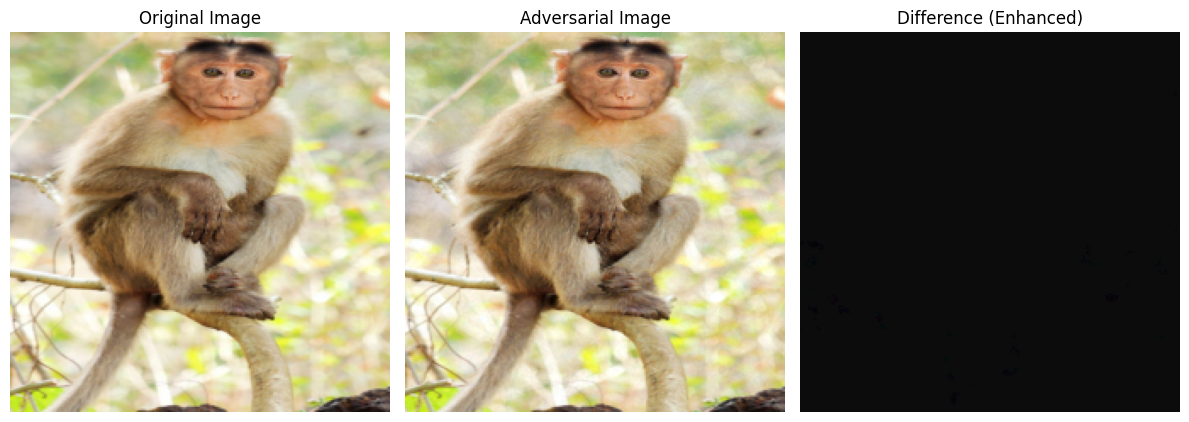

Perturbation statistics:
L2 distance: 3.872398
L0 norm (changed pixels): 150510
L∞ norm (max change): 0.010000


In [17]:
image_tensor = load_and_normalize_image("../images/monke.jpg")  # Load and preprocess image
adv_image = fgsm_attack(model, image_tensor, eps=0.01)
if adv_image is not None:
    display_adversarial_sample(image_tensor, adv_image)  # Display original and adversarial images
else:
    print("No adversarial image generated.")